In [1]:
import pystan as ps
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt


# used to force examples to run from local copy, rather than installed copy
import os, sys; sys.path.insert(0, os.path.abspath('../'))
import btom as bt

In [3]:
b = qt.Bloch()

In [4]:
b.font_size

20

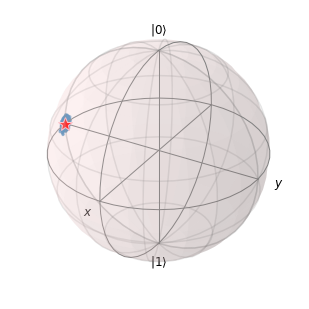

In [15]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=1)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [1000,0,1000], [500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot(alpha=0.5)

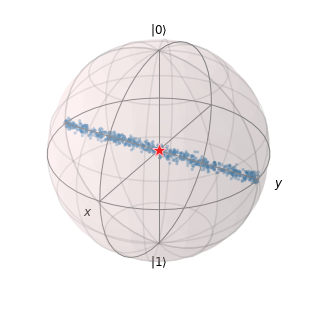

In [5]:
sampler = bt.BinomialGinibreStateSampler(ginibre_dim=2)
meas_ops = (bt.pauli_basis()[1:] + np.eye(2)) / 2
data = bt.BinomialTomographyData(meas_ops, [5000,0,1000], [2500,0,500])
pos = bt.StatePosterior(sampler, data)
a = pos.bloch_plot()